<a href="https://colab.research.google.com/github/DJ-Adams/Prediction-of-Product-Sales/blob/main/Prediction_Of_Product_Sales_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Prediction of Product Sales**
- ###### Author: Darlene Adams



#**CRISP-DM 1: Business Understanding**




#**Description**

*The goal of this data analysis report is to help the retailers understand which properties of products and outlets play crucial roles in increasing sales by using data visuals and machine learning models*

***The target is Item_Outlet_Sales.***






**Original Data Source**
 - https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/


##**Data Dictionary**
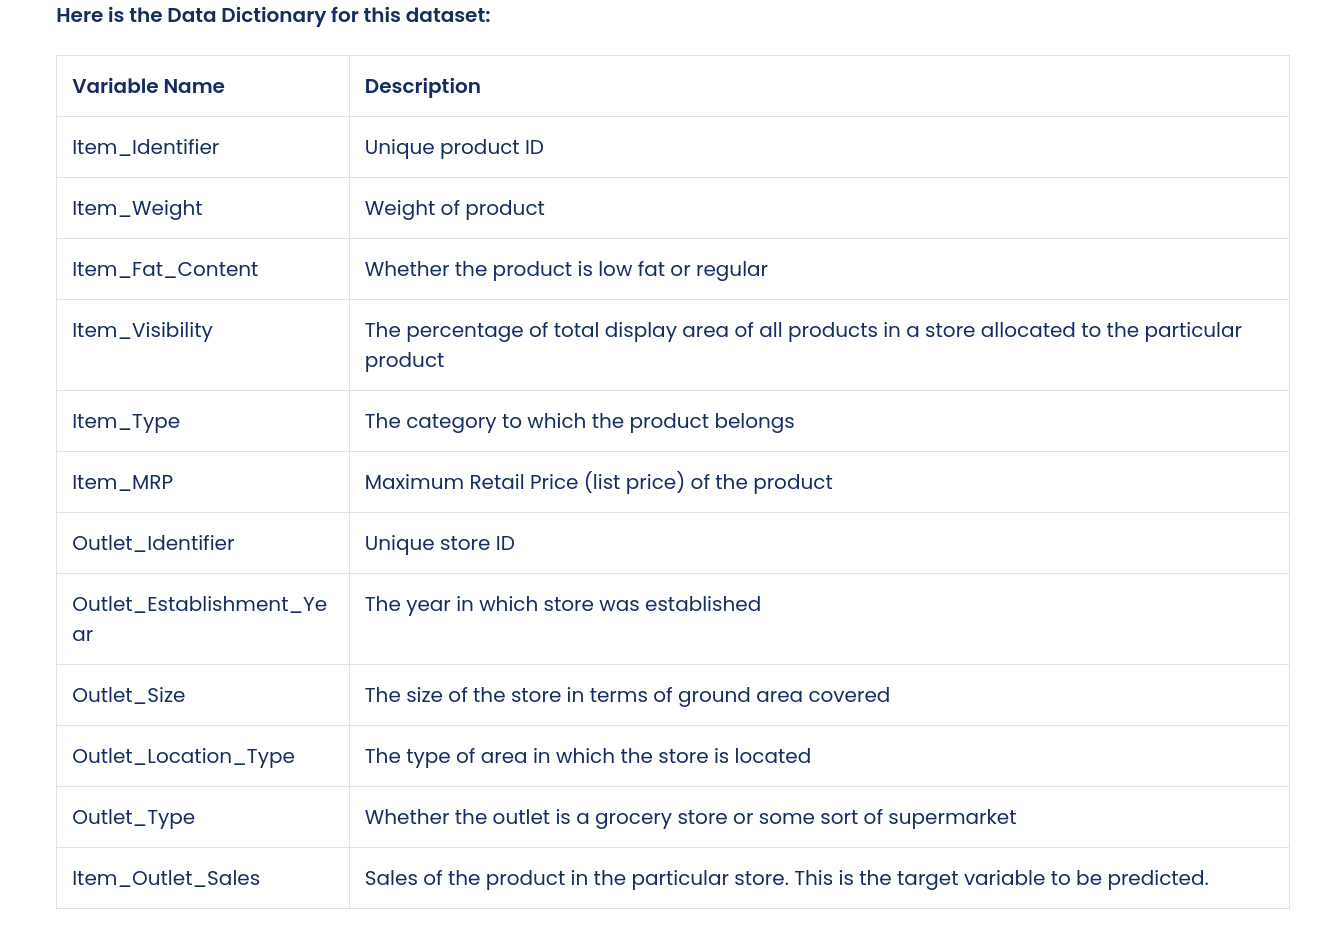

##**Imports**

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# MatplotLib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns

## Using three seaborn styles: dark_background, seaborn-muted and seaborn-poster.
plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])

# Warnings
import warnings

# Model Validation Train Test Spit
from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Balance Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#  SK Learn Display
from sklearn import set_config


###**Defaults & Runtime Configurations**

In [ ]:
# Set filter warnings to ignore
warnings.filterwarnings('ignore')

In [ ]:
# Display all columns
pd.set_option('display.max_column', None)

# Display all rows
pd.set_option('display.max_rows', None)

In [ ]:
# SK Learn Display
set_config(display='diagram')

###**Custom Functions**

In [ ]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                         output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                         label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                        output_dict=True,figsize=figsize,
                                        colorbar=colorbar, cmap=cmap_test,
                                        label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

#**CRISP-DM 2: Data Understanding**

##**Load the Data**

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load in the data
fname = "/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv"
df = pd.read_csv(fname)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


###Make a copy of original data set

In [ ]:
# Make a copy of original df
eda_ml = df.copy()

In [ ]:
# Display the first five rows of the dataframe
eda_ml.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##**Inspect the Data**

###**Check for Duplicated, Missing, or Erroneous Data**

In [ ]:
# Check to see if there are any duplicate rows
eda_ml.duplicated().sum()
print(f'There are {eda_ml.duplicated().sum()} duplicate rows.')

0

In [ ]:
# Display the number of rows and columns for the dataframe
eda_ml.shape
print(f'There are {eda_ml.shape[0]} rows, and {eda_ml.shape[1]} columns.')
print(f'The rows represent {{eda_ml.shape[0]} observations, and the columns represent {{eda_ml.shape[1]-1} features and 1 target variable.')

In [ ]:
# Display summary info
eda_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


In [ ]:
# Display the sum of missing values
eda_ml.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Missing values will be addressed when splitting the data into test and training sets.

###**Identify and address any inconsistencies in categorical values**

In [ ]:
# Identify string columns and save as variable
string_cols = eda_ml.select_dtypes("object").columns
string_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [ ]:
# Obtain the value counts for all string columns

for col in string_cols:
  print(f"Value Counts for {col}")

  print(eda_ml[col].value_counts())

  # Increasing readability by adding an empty line
  print('\n')

Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64


Value Counts for Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, 

- The Item_Fat_content column needs to be standardized to the two options in the data dictionary
- Outlet_Size is listed as High instead of large.

#**CRISP-DM: Prepare the Data**

###**Clean the Data**

In [ ]:
# Drop unneccessary columns
eda_ml = eda_ml.drop('Item_Identifier', axis=1)

In [ ]:
# Standardize the values in the Item fat content column
eda_ml['Item_Fat_Content'] = eda_ml['Item_Fat_Content'].replace({'LF':"Low Fat",'low fat':'Low Fat','reg' : "Regular"})
eda_ml['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# Standardize the values in the outlet size column column
eda_ml['Outlet_Size'] = eda_ml['Outlet_Size'].replace({'High':"Large"})
eda_ml['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

###**Identify and address any inappropriate or unusual data points**

In [ ]:
# Display statitistics for all numeric columns
eda_ml.describe(include='number').round()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


- There are no known incosistencies.

In [ ]:
# Display statitistics for all object columns
eda_ml.describe(include='object')

,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,6113,8523,8523
unique,2,16,10,3,3,4
top,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,5517,1232,935,2793,3350,5577


- There are no known incosistencies

In [ ]:
# Check target for null values
eda_ml['Item_Outlet_Sales'].isna().sum()

0

In [ ]:
# Check ordinal categories
eda_ml['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

###**Split the Data**

####**Check the Class Balance

In [ ]:
# Check how many samples of each class are present
eda_ml['Item_Outlet_Sales'].value_counts(normalize=False)

In [ ]:
# Check how many samples of each class are present in percentage
eda_ml['Item_Outlet_Sales'].value_counts(normalize=True)

In [ ]:
# Split X and y, we are predicting Item_Outlet_Sales
target = 'Item_Outlet_Sales'
X = eda_ml.drop(columns=[target]).copy()
y = eda_ml[target].copy()

# split training and test

# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
X_train.shape

(5966, 10)

In [ ]:
X_test.shape

(2557, 10)

In [ ]:
y_train.shape

(5966,)

In [ ]:
y_test.shape

(2557,)

In [ ]:
X_train.dtypes

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

In [ ]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

##**Preprocessing for Machine Learning**

###**Create the Pipelines and Tuples for Each Group of Columns**

####Numeric

In [ ]:
# PREPROCESSING FOR NUMERIC DATA

# Create the preprocessing pipeline for numeric data
num_selector = make_column_selector(dtype_include='number')

# Transformers
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Pipeline
num_pipeline = make_pipeline(median_imputer, scaler)

# Make the tuple for ColumnTransformer
num_tuple = ('numeric',num_pipeline, num_selector)
num_tuple

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

- I am using the median to fill in any missing values so as not to allow outliers to heavily skew the set

####Ordinal

In [ ]:
# PREPROCESSING PIPELINE FOR ORDINAL DATA

# Save list of ordinal column names
ordinal_cols = ['Outlet_Size']

# Ordered Category Lists
Outlet_Size_list = ['Small', 'Medium', 'Large']

# Transformers

ord = OrdinalEncoder(categories=[Outlet_Size_list])
impute_missing = SimpleImputer(strategy='most_frequent')

# Scaler
scaler2 = StandardScaler()

# Pipeline
ord_pipeline = make_pipeline(impute_missing, ord, scaler2)

In [ ]:
# Tuple
ord_tuple = ('ordinal',ord_pipeline, ordinal_cols)
ord_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                ('standardscaler', StandardScaler())])

- I chose most frequent in an attempt to keep some balance and commonality to the column

####Categorical

In [ ]:
# PREPROCESSING  FOR ONE-HOT-ENCODED DATA

# Create the preprocessing pipeline for categorical data
cat_selector = make_column_selector(dtype_include='object')

# Insantiate transfomers
freq_imputer = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Instantiate the pipeline
cat_pipe = make_pipeline(freq_imputer, ohe)

# Make a tuple for column transformer
cat_tuple = ('categorical',cat_pipe, cat_selector)
cat_tuple


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

- I chose most frequent in an attempt to keep some balance and commonality to the column

###**Create Column Transformer to Apply Different Preprocessing to Different Columns**

In [ ]:
# Instantiate the make column transformer
col_transformer = ColumnTransformer([numeric_tuple,
                                       ord_tuple,
                                       ohe_tuple],
                                       remainder='drop', verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categ...
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

##Fit the Column Transformer on the Training Data Only

In [ ]:
# Fit the column transformer on the X_train
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categ...
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

##Transform Both Training and Testing Data


In [ ]:
# Set the default transformation output to Pandas
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
# Transform the X_train and the X_test
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

##Check the Results

In [ ]:
# Display the first (5) rows of the dataframe
display(X_train_processed.head())
# Check the shape
print(f'\nshape of processed data is: {X_train_processed.shape}')
# Check the data types
print(f'\nThe datatypes are {X_train_processed.dtypes}')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
1921,-1.237957,1.606681,-0.401895,0.015833,0.284752,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
655,1.616571,-1.008442,-0.619284,-0.103437,-1.384039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2229,0.000000,-0.227068,-0.202535,-1.534680,0.284752,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2537,1.521657,1.028038,1.290187,0.492914,0.284752,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3528,1.284373,0.515355,0.686853,-1.296139,1.953543,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0



shape of processed data is: (5966, 40)

The datatypes are Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Outlet_Size                        float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              flo

In [ ]:
# Display the first (5) rows of the dataframe
display(X_test_processed.head())
# Check the shape
print(f'\nshape of processed data is: {X_test_processed.shape}')
# Check the data types
print(f'\nThe datatypes are {X_test_processed.dtypes}')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.323372,-0.773586,-0.996194,-1.296139,1.953543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2957,-1.188127,0.104028,-1.582592,-0.103437,-1.384039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,0.370829,-0.479716,-1.593182,0.135104,0.284752,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1084,0.000000,-0.412111,0.509262,-1.534680,0.284752,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
856,-0.650679,-1.044566,0.889407,0.731455,-1.384039,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0



shape of processed data is: (2557, 40)

The datatypes are Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Outlet_Size                        float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              flo

#**Project 1 - Part 6 (Core)**
**CRISP-DM Phase 4 - Modeling**

1. Your first task is to build a linear regression model to predict sales.

- Build a linear regression model.
- Use the custom evaluation function to get the metrics for your model (on training and test data).
- Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

2. Your second task is to build a Random Forest model to predict sales.

- Build a default Random Forest model.
- Use the custom evaluation function to get the metrics for your model (on training and test data).
- Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?
- Compare this model's performance to the linear regression model: which model has the best test scores?

3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.

- After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).
- Compare your tuned model to your default Random Forest: did the performance improve?


**CRISP-DM Phase 5 - Evaluation**

4. You now have tried several different models on your data set. You need to determine which model to implement.

- Overall, which model do you recommend?
- Justify your recommendation.
-In a Markdown cell:
  - Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.
  - Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
  - Include why you selected this metric to explain to your stakeholder.
  - Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?


##1.Your first task is to build a linear regression model to predict sales.

###Build a linear regression model.

####Import Libraries

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Instantiate the model
lin_reg = LinearRegression()

In [ ]:
# Fit the model on the training data
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

In [ ]:
## SK Learn Display
set_config(display='diagram')

## Transformers output as a Pandas Dataframe
set_config(transform_output='pandas')

In [ ]:
## Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
def regression_metrics(y_true, y_pred, label='', verbose=True, output_dict=False):

  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

In [ ]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose=True,
                        output_frame=False, model_name=''):


  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label= model_name + ' ' + 'Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label=model_name + ' ' + 'Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train, results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

###Use the custom evaluation function to get the metrics for your model (on training and test data).

In [ ]:
lin_reg_metrics = evaluate_regression(lin_reg, X_train_processed, y_train, X_test_processed, y_test, verbose = True,
                        output_frame=True, model_name = 'Linear model')
lin_reg_metrics

------------------------------------------------------------
Regression Metrics: Linear model Training Data
------------------------------------------------------------
- MAE = 847.668
- MSE = 1,298,672.844
- RMSE = 1,139.593
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Linear model Test Data
------------------------------------------------------------
- MAE = 810.408
- MSE = 1,210,349.624
- RMSE = 1,100.159
- R^2 = 0.568


,MAE,MSE,RMSE,R^2
Linear model Training Data,847.668,1298672.844,1139.593,0.561
Linear model Test Data,810.408,1210349.624,1100.159,0.568


In [ ]:
# Save the results as a dataframe
results_df = evaluate_regression(lin_reg, X_train_processed, y_train, X_test_processed, y_test,
                              output_frame=True, model_name = 'Linear Model')
results_df

------------------------------------------------------------
Regression Metrics: Linear Model Training Data
------------------------------------------------------------
- MAE = 847.668
- MSE = 1,298,672.844
- RMSE = 1,139.593
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Linear Model Test Data
------------------------------------------------------------
- MAE = 810.408
- MSE = 1,210,349.624
- RMSE = 1,100.159
- R^2 = 0.568


,MAE,MSE,RMSE,R^2
Linear Model Training Data,847.668,1298672.844,1139.593,0.561
Linear Model Test Data,810.408,1210349.624,1100.159,0.568


###Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

- The model performed nearly the same on both data sets. The R^2 is almost identical, so it is neither underfit or overfit.

##2. Your second task is to build a Random Forest model to predict sales.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train_processed.dtypes

Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Outlet_Size                        float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Iden

In [ ]:
# Instantiate default random forest model
default_rf = RandomForestRegressor(random_state = 42)

## Create a model pipeline
rf_pipe = make_pipeline(col_transformer, default_rf)

# Fit default model on training data only
rf_pipe.fit(X_train, y_train)

# Evaluate with custom function
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

# Save the results as a datframe
rf_results_df = evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test,
                                    output_frame=True, model_name = 'Forest Model')
rf_results_df

------------------------------------------------------------
Regression Metrics:  Training Data
------------------------------------------------------------
- MAE = 296.836
- MSE = 182,909.354
- RMSE = 427.679
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics:  Test Data
------------------------------------------------------------
- MAE = 776.805
- MSE = 1,245,831.112
- RMSE = 1,116.168
- R^2 = 0.555
------------------------------------------------------------
Regression Metrics: Forest Model Training Data
------------------------------------------------------------
- MAE = 296.836
- MSE = 182,909.354
- RMSE = 427.679
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Forest Model Test Data
------------------------------------------------------------
- MAE = 776.805
- MSE = 1,245,831.112
- RMSE = 1,116.168
- R^2 = 0.555


,MAE,MSE,RMSE,R^2
Forest Model Training Data,296.836,182909.354,427.679,0.938
Forest Model Test Data,776.805,1245831.112,1116.168,0.555


###Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

- There is high variance withe R^2 with the model performing significantly worse on the test. Highly Overfit

###Compare this model's performance to the linear regression model: which model has the best test scores?

In [ ]:
metrics = pd.concat([rf_results_df, results_df])
metrics.sort_values('R^2')

,MAE,MSE,RMSE,R^2
Forest Model Test Data,776.805,1245831.112,1116.168,0.555
Linear Model Training Data,847.668,1298672.844,1139.593,0.561
Linear Model Test Data,810.408,1210349.624,1100.159,0.568
Forest Model Training Data,296.836,182909.354,427.679,0.938


- The Linear Model Test performed slightly better in R^2.
- The MAE has a better score for the Forest Model.
- The RMSE indicates there are not many large errors in the data and they are within $500 of the MAE.

##3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categ...
                                                     StandardScaler())]),
                           

In [ ]:
# Define Param Grid
param_rf_grid = {'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
              'randomforestregressor__n_estimators' : [50],
              'randomforestregressor__min_samples_leaf' : [1, 2, 3, 4, 5, 10],
                'randomforestregressor__min_samples_split' : [2, 3, 4] }

In [ ]:
# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(rf_pipe, param_rf_grid, n_jobs = -1, verbose = 1)

- **Note** It took me ten minutes to fit this

In [ ]:
# Fit the Gridsearch on the training data
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strat...
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10,
                                                              None],
                         'randomforestregressor__min_samples_leaf': [1, 2, 3, 4,
                                                                     5, 10],
                         'randomforestregressor__min_samples_split': [2, 3, 4],
                         'randomforestregressor__n_estimators': [50]},
             verbose=1)

In [ ]:
# Obtain the best combination of parameters
grid_search_rf.best_params_

{'randomforestregressor__max_depth': 5,
 'randomforestregressor__min_samples_leaf': 10,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 50}

###After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).


In [ ]:
# Fit and evaluate best version of the model with no folds
best_rf_model = grid_search_rf.best_estimator_

# Use custom function to evalute the model
evaluate_regression( best_rf_model, X_train, y_train, X_test, y_test)

# Save the results as a datframe
rf_tuned_df = evaluate_regression( best_rf_model, X_train, y_train, X_test, y_test,
                                    output_frame=True, model_name = 'Tuned Model')


------------------------------------------------------------
Regression Metrics:  Training Data
------------------------------------------------------------
- MAE = 755.080
- MSE = 1,154,970.834
- RMSE = 1,074.696
- R^2 = 0.609

------------------------------------------------------------
Regression Metrics:  Test Data
------------------------------------------------------------
- MAE = 736.898
- MSE = 1,116,035.094
- RMSE = 1,056.426
- R^2 = 0.602
------------------------------------------------------------
Regression Metrics: Tuned Model Training Data
------------------------------------------------------------
- MAE = 755.080
- MSE = 1,154,970.834
- RMSE = 1,074.696
- R^2 = 0.609

------------------------------------------------------------
Regression Metrics: Tuned Model Test Data
------------------------------------------------------------
- MAE = 736.898
- MSE = 1,116,035.094
- RMSE = 1,056.426
- R^2 = 0.602


###Compare your tuned model to your default Random Forest: did the performance improve?

In [ ]:
metrics = pd.concat([rf_results_df, results_df, rf_tuned_df])
metrics.sort_values('R^2')

,MAE,MSE,RMSE,R^2
Forest Model Test Data,776.805,1245831.112,1116.168,0.555
Linear Model Training Data,847.668,1298672.844,1139.593,0.561
Linear Model Test Data,810.408,1210349.624,1100.159,0.568
Tuned Model Test Data,736.898,1116035.094,1056.426,0.602
Tuned Model Training Data,755.080,1154970.834,1074.696,0.609
Forest Model Training Data,296.836,182909.354,427.679,0.938


- The tuned model had less variance and performed nearly the same on both data sets.
- The tuned model performed significantly better than the default forest model.

##CRISP-DM Phase 5 - Evaluation

###You now have tried several different models on your data set. You need to determine which model to implement.

- Overall, which model do you recommend? Justify your recommendation.
  - I would recommend the tuned model. It performs nearly the same on both data sets with the R^2 indicating that it can explain 60% of the variation in the target.

  - All models have high bias on the testing data.

###In a Markdown cell:
- Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.
- Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
- Include why you selected this metric to explain to your stakeholder.
- Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

- R^2 being nearly identical means that the 60% of the variance can be explained which means the models may not have been able to address the noise in the data sets.


- The MAE and RMSE are both relatively low and within 400 of each other indicating there aren't many large errors. 736 dollars and 1056 dollars on the test data respectively.

- These are good numbers to have a baseline to continue the tuning process.

- Both models performed nearly the same.